API Key: ··········
API Key registrada.
Procesada: San José
Procesada: New York
Procesada: Madrid
Procesada: Buenos Aires
Procesada: Tokyo
Datos cargados en SQLite sin duplicados.


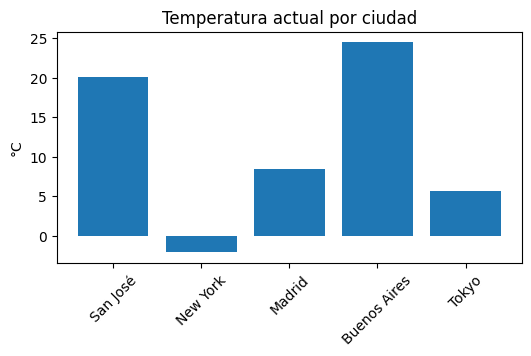

In [1]:

import requests
import pandas as pd
from datetime import datetime
from getpass import getpass
import sqlite3

API_KEY = getpass("API Key: ")
print("API Key registrada.")
url = "https://api.openweathermap.org/data/2.5/weather"
params = {
    "appid": API_KEY,
    "units": "metric",
    "lang": "es"
}

def transformar_datos_clima(data_json):
    ciudad = data_json.get("name")
    temperatura = data_json["main"].get("temp")
    humedad = data_json["main"].get("humidity")
    descripcion = data_json["weather"][0].get("description")
    sensacion_termica = data_json["main"].get("feels_like")
    fecha_unix = data_json.get("dt")
    fecha_iso = datetime.fromtimestamp(fecha_unix).isoformat()

    return {
        "ciudad": ciudad,
        "temperatura": temperatura,
        "humedad": humedad,
        "descripcion": descripcion,
        "fecha": fecha_iso,
        "sensacion_termica": sensacion_termica
    }

ciudades = [
    "San Jose,CR", "New York,US", "Madrid,ES",
    "Buenos Aires,AR", "Tokyo,JP"
]

resultados = []

for ciudad in ciudades:
    params["q"] = ciudad
    response = requests.get(url, params=params)

    if response.status_code == 200:
        registro = transformar_datos_clima(response.json())
        resultados.append(registro)
        print(f"Procesada: {registro['ciudad']}")
    else:
        print(f"Error con {ciudad}: {response.text}")

df = pd.DataFrame(resultados)
df


conn = sqlite3.connect("clima.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS clima_ciudades (
    ciudad TEXT,
    temperatura REAL,
    humedad REAL,
    descripcion TEXT,
    fecha TEXT,
    sensacion_termica REAL,
    UNIQUE(ciudad, fecha)
);
""")
conn.commit()

for _, fila in df.iterrows():
    try:
        cursor.execute("""
            INSERT INTO clima_ciudades (ciudad, temperatura, humedad, descripcion, fecha, sensacion_termica)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            fila["ciudad"], fila["temperatura"], fila["humedad"],
            fila["descripcion"], fila["fecha"], fila["sensacion_termica"]
        ))
    except sqlite3.IntegrityError:
        pass

conn.commit()
conn.close()

print("Datos cargados en SQLite sin duplicados.")

import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(df["ciudad"], df["temperatura"])
plt.title("Temperatura actual por ciudad")
plt.xticks(rotation=45)
plt.ylabel("°C")
plt.show()

df.to_csv("clima_ciudades_for_powerbi.csv", index=False)